In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
os.environ['MKL_NUM_THREADS'] = "1"
os.environ['NUMEXPR_NUM_THREADS'] = "1"
os.environ['OMP_NUM_THREADS'] = "1"
os.environ['OPENBLAS_NUM_THREADS'] = "1"
os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import pandas as pd
import astropy
#from icecube import astro
import histlite as hl
import healpy
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = '/home/mhuennefeld/public_html/analyses/DNNCascade/plots/review/bkg_ts_flucuations'
    
elif 'phobos' in host_name:
    print('Working on Phobos')
    data_prefix = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/data/cscd/final'
    ana_dir = '/net/big-tank/POOL/users/mhuennefeld/analyses/DNNCascade/csky/analyses/'
    plot_dir = '/home/mhuennefeld/analyses/DNNCascade/plots/review/bkg_ts_flucuations'
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
class DNNCascade_10yr_mc_weights(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    def dataset_modifications(self, ds):
        print('Adding weights to MC')
        path_sig_df = (
            '/data/ana/PointSource/DNNCascade/analysis/' + 
            self._path_sig.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
        )
        df = pd.read_hdf(path_sig_df, key='df')
        assert np.allclose(df['run'], ds.sig.run)
        assert np.allclose(df['energy'], ds.sig.energy)
        assert np.allclose(df['ow'], ds.sig.oneweight)
        for k in df.keys():
            if 'weight' in k or 'veto' in k:
                ds.sig[k] = df[k]

sigma_floor_deg = 4
sigma_floor = np.deg2rad(sigma_floor_deg)

class DNNCascade_10yr_mc_weights_floor(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
    def dataset_modifications(self, ds):
        print('Adding weights to MC')
        path_sig_df = (
            '/data/ana/PointSource/DNNCascade/analysis/' + 
            self._path_sig.format(version=self._version).replace('dnn_cascades/', '').replace('.npy', '.hdf')
        )
        df = pd.read_hdf(path_sig_df, key='df')
        assert np.allclose(df['run'], ds.sig.run)
        assert np.allclose(df['energy'], ds.sig.energy)
        assert np.allclose(df['ow'], ds.sig.oneweight)
        for k in df.keys():
            if 'weight' in k or 'veto' in k:
                ds.sig[k] = df[k]
        
        # angular error floor
        ds.sig['sigma'] = np.clip(ds.sig['sigma'], sigma_floor, np.inf)
        ds.data['sigma'] = np.clip(ds.data['sigma'], sigma_floor, np.inf)
                
specs = [DNNCascade_10yr_mc_weights]
specs_floor = [DNNCascade_10yr_mc_weights_floor]


In [6]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr_mc_weights
Setting up DNNCascade_10yr_mc_weights...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/ve

In [7]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_conv, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_pr, nuveto_pf_dnn_cascade_selection_H3a_SIBYLL2_3c_total, ra, run, sigma, sindec, subevent, weights, weights_MCEq_H3a_sibyll2_3c_conv, weights_MCEq_H3a_sibyll2_3c_pr, weights_MCEq_H3a_sibyll2_3c_total, weights_aachen_flux, weights_aachen_flux_8yr, weights_cscd_hans, weights_cscd_icrc15, weights_global_fit, weights_hese4_bestfit, weights_hese4_fixed, weights_hese6, weights_hese_flux, weights_livetime, weights_mese_flux, weights_meta_info_n_events_per_run, weights_meta_info_n_files, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [8]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

In [9]:
%%time

ana_floor = cy.get_analysis(
    repo, selection_version, specs_floor, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr_mc_weights_floor
Setting up DNNCascade_10yr_mc_weights_floor...
Adding weights to MC
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
CPU times: user 13.4 s, sys: 6.21 s, total: 19.6 s
Wall time: 19.5 s


In [10]:
a_floor = ana_floor.anas[0]
print(np.rad2deg([min(a_floor.sig.sigma), min(a_floor.bg_data.sigma)]))

[3.9999998 3.9999998]


## Helper Functions

In [11]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_color_cycler():
    return cycle(colors)

def get_toy_exp_data(seed, livetime, df):
    df = deepcopy(df)
    rng = np.random.RandomState(seed)
    
    assert np.allclose(df.weights_livetime, df.weights_livetime[0])
    
    n_events = np.sum(df.weights * livetime / df.weights_livetime[0])
    print('Sampling from Poisson with: {} events'.format(n_events))
    
    p = df.weights / np.sum(df.weights)
    idx = np.random.choice(range(len(df)), size=rng.poisson(n_events), replace=True, p=p)
    
    toy_data = df[idx]
    return toy_data

def get_toy_ana(livetime, seed):
    """Get ana toy dataset"""
    class DNNCascade_10yr_mod(cy.selections.DNNCascadeDataSpecs.DNNCascade_10yr):
        def dataset_modifications(self, ds):
            sig = copy.deepcopy(ds.sig)
            data = copy.deepcopy(ds.data)
            ds.data = get_toy_exp_data(seed=seed, livetime=livetime, df=a.sig)

    specs = [DNNCascade_10yr_mod]
    repo = cy.selections.Repository()
    ana_mod = cy.get_analysis(repo, selection_version, specs)
    return ana_mod
    

def get_trial_runner(sindec, gamma, ana, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.DecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        #'cut_n_sigma': 100, #---------------------------new
        #'dec_rand_kwargs' : dict(randomization_width = np.radians(15)), # -- new
        'dec_rand_kwargs' : dict(randomization_width = np.radians(3)),
        'dec_rand_method' : 'gaussian_fixed',
        'dec_rand_pole_exlusion' : np.radians(8),
        'bg_replace': True,
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_sindec_jitter(sindec, gamma, ana, cpus, ra=0., cutoff_TeV=np.inf, sigsub=True):
    src = cy.utils.sources(ra, np.arcsin(sindec), deg=False)
    print('Using jitter')
    cutoff_GeV = cutoff_TeV * 1e3
    conf = {
        'src' : src, 
        'flux' : cy.hyp.PowerLawFlux(gamma, energy_cutoff = cutoff_GeV),
        'update_bg': True,
        'sigsub' :  sigsub,
        'randomize' : ['ra', cy.inj.SinDecRandomizer],
        'sindec_bandwidth' : np.radians(5),
        'sindec_jitter' : 0.10,
        'cut_n_sigma': 100, #---------------------------new
        'bg_replace': True,
    }
    tr = cy.get_trial_runner(ana=ana, conf= conf, mp_cpus=cpus)
    return tr, src

def get_trial_runner_no_sigsub(*args, **kwargs):
    if 'sigsub' in kwargs: raise KeyError('sigsub is defined!')
    return get_trial_runner(*args, sigsub=False, **kwargs)

def get_bkg_trials(sindec, gamma, ana, cpus=20, sigsub=True, cutoff_TeV=np.inf, n_trials=10000, return_trials=False, tr_func=get_trial_runner, seed=None):
    
    # get trial runner
    trial_runner, src = tr_func(
        sindec, ra=0., gamma=gamma, ana=ana, sigsub=sigsub, cpus=cpus, cutoff_TeV=cutoff_TeV)
    
    # get background trials
    print('Performing BG Trials at RA: {}, DEC: {}'.format(src.ra_deg, src.dec_deg))
    bkg_trials = trial_runner.get_many_fits(n_trials=n_trials, cpus=cpus, seed=seed)
    
    if return_trials:
        return bkg_trials
    else:
        return cy.dists.Chi2TSD(bkg_trials)

def run_toy_trials(livetime, seed, **kwargs):
    """Run bkg trials with a toy MC as background"""
    # get analysis
    ana_mod = get_toy_ana(livetime=livetime, seed=seed)
    
    # get trial runner and run bkg trials
    bg = get_bkg_trials(ana=ana_mod, seed=seed, **kwargs)
    
    return bg

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    x = h.centers[0]
    norm = h.integrate().values
    if label_fit is not None:
        label_fit = label_fit.format(bg.ndof, bg.eta)
    if density:
        ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
    else:
        ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

def plot_bkg_trials_range(
            bgs, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit_median=r'$\chi^2[{:.2f}$ dof $\eta={:.3f}]$ | Median', 
            label_fit=r'$\chi^2[{:.2f}$ dof $\eta={:.3f}]$ | Sample {}', 
            color=colors[0],
            bins=np.linspace(0, 20, 50),
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    total_bg = bgs[0]
    for bg in bgs[1:]:
        total_bg += bg
    hs = [bg.get_hist(bins=bins) for bg in bgs]
    if label is not None:
        label = label.format(bgs[0].n_total)
    
    # get median values
    hs_values = np.array([h.values for h in hs])
    h_median = hl.Hist(bins=bins, values=np.median(hs_values, axis=0))
    h_min = hl.Hist(bins=bins, values=np.min(hs_values, axis=0))
    h_max = hl.Hist(bins=bins, values=np.max(hs_values, axis=0))
    
    # plot range
    hl.fill_between(ax, h_min, h_max, color=color, alpha=.3, drawstyle='line')
    hl.plot1d (ax, h_median, color=color, lw=2, drawstyle='default')
    
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h_median, crosses=True, color=color, label=label)
    
    # chi2 fit for median hist:
    x = h_median.centers[0]
    norm = h_median.integrate().values
    if label_fit_median is not None:
        label_fit_median = label_fit_median.format(total_bg.ndof, total_bg.eta)
    ax.semilogy(x, norm * total_bg.pdf(x), lw=1, ls='--', label=label_fit_median, color=color)
    
    # compare with the chi2 fit:
    for i, (h, bg) in enumerate(zip(hs, bgs)):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit_i = label_fit.format(bg.ndof, bg.eta, i)
        ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit_i, color=color, alpha=0.3)

    ax.set_xlabel(r'TS')
    ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax


## Run Background Trials

In [12]:
sindecs = [-0.8, -0.4, 0.0, 0.4, 0.8]
#sindecs = [-0.4]
cpus = 20
gamma = 2.5
n_trials = 100000


#### Exp Data

In [108]:
trials_dict_exp = {}

for sindec in sindecs:
    for i in range(1):
        bg = get_bkg_trials(sindec, gamma, ana, cpus=cpus, sigsub=True, cutoff_TeV=np.inf, n_trials=n_trials)
        
        # save data
        trials_dict_exp[(sindec, i)] = bg

        with open(os.path.join(plot_dir, 'trials_exp.pkl'), 'wb') as f:
            pickle.dump(trials_dict_exp, f, protocol=2)
            

Performing BG Trials at RA: [0.], DEC: [-53.13010235]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
Performing BG Trials at RA: [0.], DEC: [-23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
Performing BG Trials at RA: [0.], DEC: [0.]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
Performing BG Trials at RA: [0.], DEC: [23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
Performing BG Trials at RA: [0.], DEC: [53.13010235]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   


#### MC background

In [114]:
trials_dict_mc = {}

for sindec in sindecs:
    for i in range(1):
        
        # create unique random seed for each trial
        seed = int((1+sindec) * 100) + i * 10000
        print('sindec: {:3.2f} | Iteration: {} | seed'.format(sindec, i, seed))
        
        # run trials
        bg = run_toy_trials(seed=seed, livetime=a.livetime * 10, sindec=sindec, gamma=gamma, cpus=10, n_trials=n_trials)
        
        # save data
        trials_dict_mc[(sindec, i)] = bg

        with open(os.path.join(plot_dir, 'trials_mc.pkl'), 'wb') as f:
            pickle.dump(trials_dict_mc, f, protocol=2)

sindec: -0.80 | Iteration: 0 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/an

NameError: name 'fasdfa' is not defined

#### Toy exp sets

In [109]:
trials_dict = {}

for sindec in sindecs:
    for i in range(10):
        
        # create unique random seed for each trial
        seed = int((1+sindec) * 100) + i * 10000
        print('sindec: {:3.2f} | Iteration: {} | seed'.format(sindec, i, seed))
        
        # run trials
        bg = run_toy_trials(seed=seed, livetime=a.livetime, sindec=sindec, gamma=gamma, cpus=cpus, n_trials=n_trials)
        
        # save data
        trials_dict[(sindec, i)] = bg

        with open(os.path.join(plot_dir, 'trials.pkl'), 'wb') as f:
            pickle.dump(trials_dict, f, protocol=2)

sindec: -0.80 | Iteration: 0 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/an

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-53.13010235]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: -0.80 | Iteration: 8 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyse

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: -0.40 | Iteration: 2 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: -0.40 | Iteration: 6 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-23.57817848]
Performing 100000 background trials using 20 cores:
     100000/100000 trials complete.   
sindec: 0.00 | Iteration: 0 | seed
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [0.]
Performing 100000 background trials using 20 cores:
     100

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...


Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/d

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_casca

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/vers

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/

## Load Trials

In [13]:
with open(os.path.join(plot_dir, 'trials_exp.pkl'), 'rb') as f:
    trials_dict_exp = pickle.load(f)
    
with open(os.path.join(plot_dir, 'trials_mc.pkl'), 'rb') as f:
    trials_dict_mc = pickle.load(f)
    
with open(os.path.join(plot_dir, 'trials.pkl'), 'rb') as f:
    trials_dict = pickle.load(f)
    

## Make Plots

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib

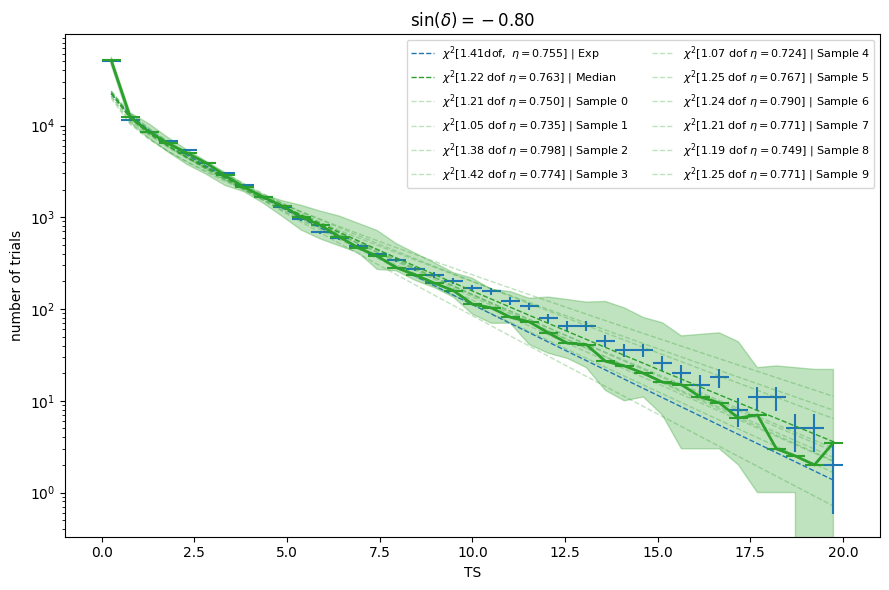

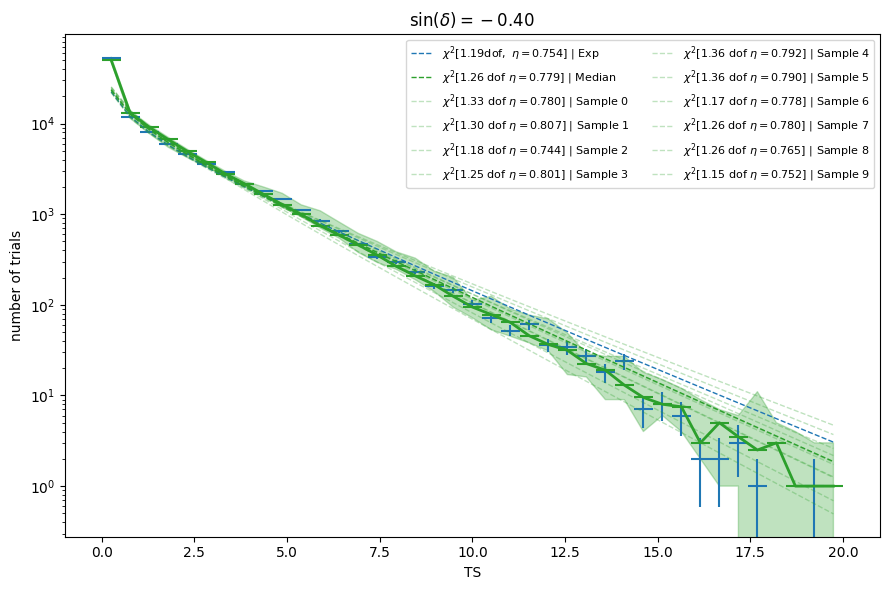

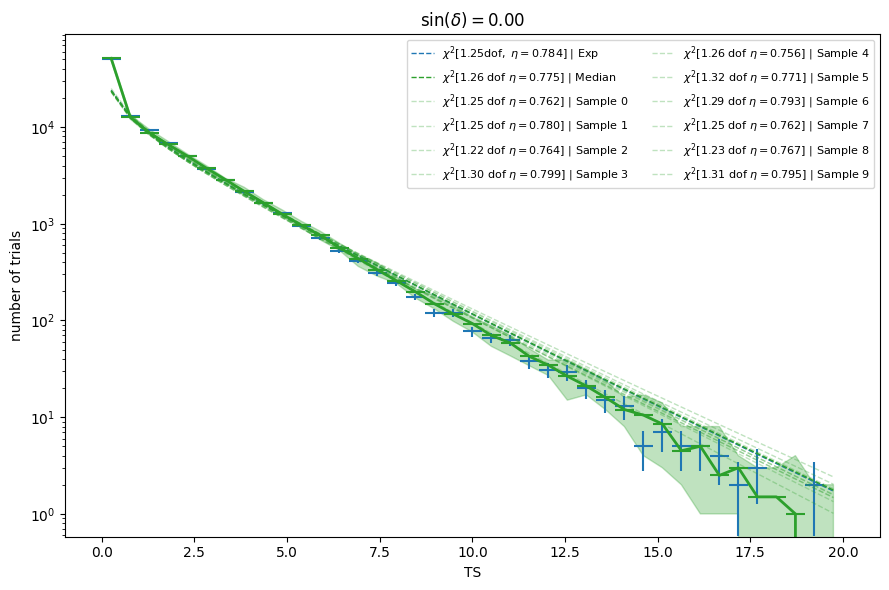

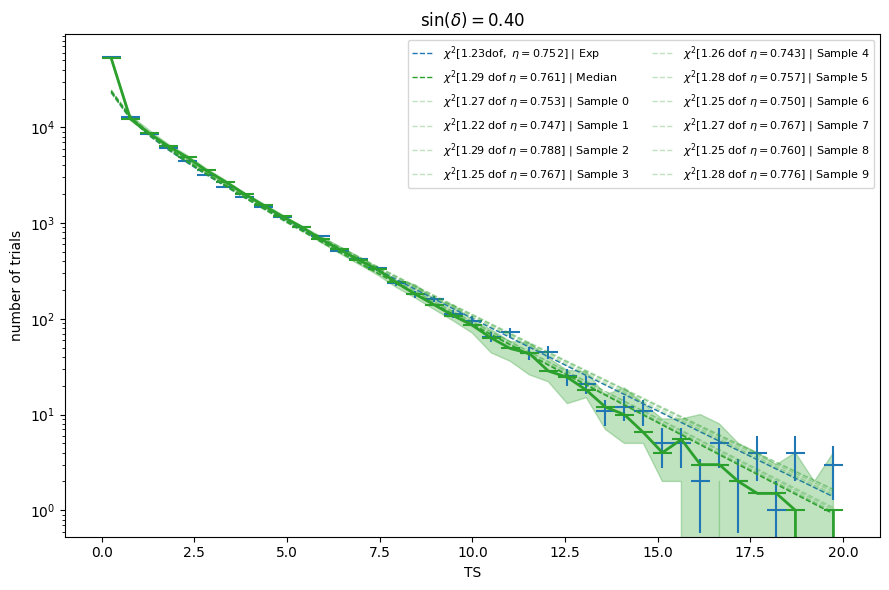

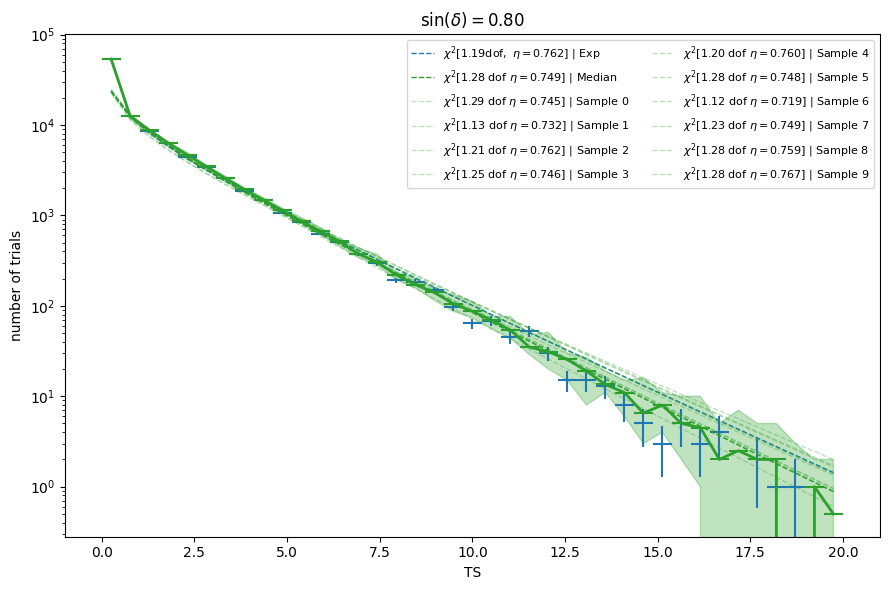

In [14]:
bins = np.linspace(0, 20, 40)
for sindec in sindecs:
    fig, ax = plt.subplots(figsize=(9, 6))
    
    # plot exp TS distribution
    plot_bkg_trials(
        trials_dict_exp[(sindec, 0)], color=colors[0], fig=fig, ax=ax, bins=bins, 
        label=None, label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ | Exp',
    )
    
    # plot MC TS distribution
    if (sindec, 0) in trials_dict_mc:
        plot_bkg_trials(
            trials_dict_mc[(sindec, 0)], color=colors[1], fig=fig, ax=ax, bins=bins, 
            label=None, label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ | MC [10x livetime]',
        )
    
    bgs = []
    for key, bg in trials_dict.items():
        if key[0] != sindec: continue
        bgs.append(bg)
        #plot_bkg_trials(bg, color='k', fig=fig, ax=ax, bins=bins, label=None)
    plot_bkg_trials_range(bgs=bgs, fig=fig, ax=ax, bins=bins, color=colors[2], label=None)
    
    ax.set_title(r'$\sin(\delta)={:3.2f}$'.format(sindec))
    ax.legend(fontsize=8, loc='upper right', ncol=2)
    
    fig.tight_layout()
    fig.savefig(os.path.join(plot_dir, 'bkg_ts_fluctuations_sindec_{:3.2f}.png'.format(sindec)))    
            

## Test Bump in Distribution

In [395]:
sindec = np.sin(np.deg2rad(-65))
n_trials = 100000

bg = get_bkg_trials(
    sindec=sindec, 
    gamma=2.5, 
    ana=ana, 
    n_trials=n_trials,
    cpus=18,
)

Performing BG Trials at RA: [0.], DEC: [-65.]
Performing 100000 background trials using 18 cores:
     100000/100000 trials complete.   


In [79]:
n_trials = 100000

bg_nsigma100 = get_bkg_trials(
    sindec=sindec, 
    gamma=2.5, 
    ana=ana, 
    n_trials=n_trials,
    cpus=25,
)

cut_n_sigma: 100
Performing BG Trials at RA: [0.], DEC: [-65.]
Performing 100000 background trials using 25 cores:
     100000/100000 trials complete.   


In [63]:
n_trials = 100000

bg2_nsigma100 = get_bkg_trials(
    sindec=sindec, 
    gamma=2.5, 
    ana=ana, 
    n_trials=n_trials,
    cpus=25,
)

cut_n_sigma: 100
Performing BG Trials at RA: [0.], DEC: [-65.]
Performing 10000 background trials using 25 cores:
      10000/10000 trials complete.   


In [23]:

bg2 = get_bkg_trials(
    sindec=sindec, 
    gamma=2.5, 
    ana=ana, 
    n_trials=n_trials,
    cpus=25,
)

Performing BG Trials at RA: [0.], DEC: [-65.]
Performing 100000 background trials using 25 cores:
     100000/100000 trials complete.   


/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


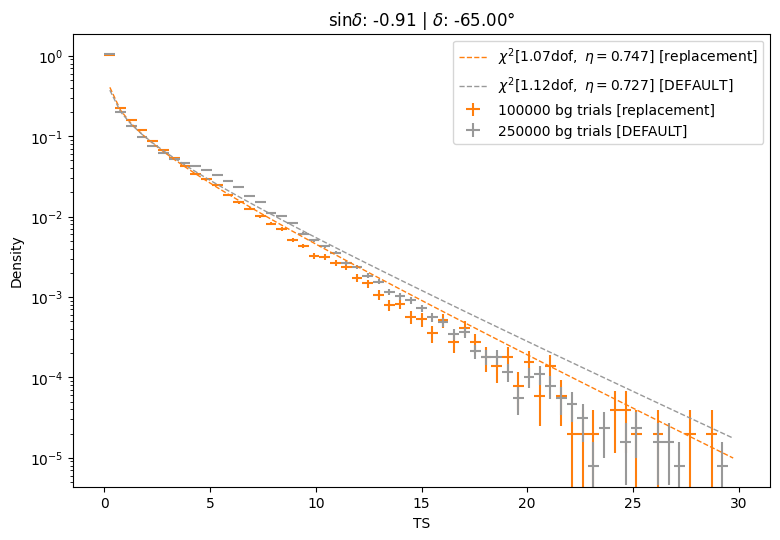

In [405]:
bins = np.linspace(0, 30, 60)
fig, ax = plt.subplots(figsize=(9, 6))
density = True
if False:
    plot_bkg_trials(bg, bins=bins, fig=fig, ax=ax, density=density)
if True:
    plot_bkg_trials(
        bg2, fig=fig, ax=ax, bins=bins,
        color=colors[1],
        density=density,
        label='{} bg trials [replacement]', 
        label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ [replacement]',
    )
if False:
    plot_bkg_trials(
        bg_nsigma100, fig=fig, ax=ax, bins=bins,
        color=colors[2],
        density=density,
        label='{} bg trials [$100 \cdot \sigma cut$]', 
        label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ [$100 \cdot \sigma cut$]',
    )
if False:
    plot_bkg_trials(
        bg2_nsigma100, fig=fig, ax=ax, bins=bins,
        color=colors[3],
        density=density,
        label='{} bg trials [$100 \cdot \sigma cut$ + replacement]', 
        label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ [$100 \cdot \sigma cut$ + replacement]',
    )
if True:
    plot_bkg_trials(
        default_bg_chi2[-65], fig=fig, ax=ax, bins=bins,
        color='0.6',
        density=density,
        label='{} bg trials [DEFAULT]', 
        label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ [DEFAULT]',
    )
ax.set_title('$\sin \delta$: {:3.2f} | $\delta$: {:3.2f}°'.format(
    sindec, np.rad2deg(np.arcsin(sindec))))
fig.savefig(os.path.join(plot_dir, 'test_replacement_sampling.png'))

In [407]:
n = 3
print(
    bg.isf_nsigma(n), 
    bg2.isf_nsigma(n),
    bg_nsigma100.isf_nsigma(n),
    bg2_nsigma100.isf_nsigma(n),
)
print(
    cy.dists.TSD(bg.trials).isf_nsigma(n), 
    cy.dists.TSD(bg2.trials).isf_nsigma(n),
    cy.dists.TSD(bg_nsigma100.trials).isf_nsigma(n),
    cy.dists.TSD(bg2_nsigma100.trials).isf_nsigma(n),
)


17.553774107786296 17.49230198132323 19.123390749271902 16.00078456778812
15.523171244703175 15.837097576605247 15.406209800447138 15.826301900876732


### Run Trials

In [15]:
np.sin(np.deg2rad(np.arange(-81, 0, 4)))


array([-0.98768834, -0.97437006, -0.95630476, -0.93358043, -0.90630779,
       -0.87461971, -0.83867057, -0.79863551, -0.75470958, -0.70710678,
       -0.65605903, -0.60181502, -0.54463904, -0.48480962, -0.42261826,
       -0.35836795, -0.2923717 , -0.22495105, -0.15643447, -0.08715574,
       -0.01745241])

In [16]:
file_addition = ''
#file_addition = '_15deg_smearing'
#file_addition = '_5deg_smearing'
#file_addition = '_0deg_smearing'
#file_addition = '_0.10_jitter'
#file_addition = '_3deg_smearing_{:3.1f}deg_floor'

if 'deg_floor' in file_addition:
    print('Using modified ana object')
    file_addition = file_addition.format(sigma_floor_deg)
    print('Saving to:', file_addition)
    ana_to_use = ana_floor
else:
    print('Using normal ana object')
    ana_to_use = ana

if 'jitter' in file_addition:
    print('Using Sindec Jitter')
    tr_func = get_trial_runner_sindec_jitter
else:
    print('Using Gaussian Smearing')
    tr_func = get_trial_runner
    
    # Some safety check
    tr, src = tr_func(sindec=0, gamma=2.5, ana=ana_to_use, cpus=1)
    inj = tr.bg_injs[0]
    set_randomization_width_deg = np.round(np.rad2deg(inj.randomizers[1].dec_rand_kwargs['randomization_width']), decimals=2)
    print('Trial runner setup with: {}°'.format(set_randomization_width_deg))
    if file_addition == '':
        assert set_randomization_width_deg == 3
    else:
        assert set_randomization_width_deg == int(file_addition[1:].split('deg_smearing')[0])
    
trial_file_path = os.path.join(plot_dir, 'trials_replace{}.pkl'.format(file_addition))
trial_file_path_mc = os.path.join(plot_dir, 'trials_replace_mc{}.pkl'.format(file_addition))

reload = True

if os.path.exists(trial_file_path) and reload:
    print('Loading dict')
    with open(trial_file_path, 'rb') as f:
        trials_replace = pickle.load(f)
else:
    print('Creating new dict')
    trials_replace = {}
    
if os.path.exists(trial_file_path_mc) and reload:
    print('Loading MC dict')
    with open(trial_file_path_mc, 'rb') as f:
        trials_replace_mc = pickle.load(f)
else:
    print('Creating new MC dict')
    trials_replace_mc = {}
    

Using normal ana object
Using Gaussian Smearing
Trial runner setup with: 3.0°
Loading dict
Loading MC dict


##### Trials for exp data scrambles

In [25]:
overwrite = False
append = True
n_trials = 90000
cpus = 18

sindecs_replace = np.sin(np.deg2rad(np.arange(-81, 0, 4)))

for sindec in sindecs_replace:
    if sindec in trials_replace:
        if not overwrite and not append:
            print('Skipping: {:3.3f}'.format(sindec))
            continue
        
        print('Appending trials to: {:3.3f}'.format(sindec))
        bg = trials_replace[sindec][0]
        seed_cnt = trials_replace[sindec][1] + 1
        seeds = trials_replace[sindec][2]
    else:
        seed_cnt = 0
        bg = cy.utils.Events({'gamma': [], 'ns': [], 'ts': []})
        seeds = []

    # create unique random seed for each trial
    seed = int((1+sindec) * 1000)  + seed_cnt * 100000
    print('sindec: {:3.2f} | seed {} | seed counter {}'.format(
        sindec, seed, seed_cnt))

    # run trials
    bg += get_bkg_trials(
        sindec=sindec, 
        gamma=2.5, 
        ana=ana_to_use, 
        n_trials=n_trials,
        cpus=cpus,
        return_trials=True,
        tr_func=tr_func,
        seed=seed,
    )
    seeds.append(seed)

    # save data
    trials_replace[sindec] = (bg, seed_cnt, seeds)

    with open(trial_file_path, 'wb') as f:
        pickle.dump(trials_replace, f, protocol=2)

Appending trials to: -0.988
sindec: -0.99 | seed 100012 | seed counter 1
Performing BG Trials at RA: [0.], DEC: [-81.]
Performing 90000 background trials using 18 cores:
      90000/90000 trials complete.   
Appending trials to: -0.974
sindec: -0.97 | seed 100025 | seed counter 1
Performing BG Trials at RA: [0.], DEC: [-77.]
Performing 90000 background trials using 18 cores:
      90000/90000 trials complete.   
Appending trials to: -0.956
sindec: -0.96 | seed 100043 | seed counter 1
Performing BG Trials at RA: [0.], DEC: [-73.]
Performing 90000 background trials using 18 cores:
      90000/90000 trials complete.   
Appending trials to: -0.934
sindec: -0.93 | seed 100066 | seed counter 1
Performing BG Trials at RA: [0.], DEC: [-69.]
Performing 90000 background trials using 18 cores:
      90000/90000 trials complete.   
Appending trials to: -0.906
sindec: -0.91 | seed 100093 | seed counter 1
Performing BG Trials at RA: [0.], DEC: [-65.]
Performing 90000 background trials using 18 cores

In [17]:
trials_replace

{-0.9876883405951378: (Events(100000 items | columns: gamma, ns, ts),
  3,
  [12, 100012, 200012, 300012]),
 -0.9743700647852352: (Events(100000 items | columns: gamma, ns, ts),
  3,
  [25, 100025, 200025, 300025]),
 -0.9563047559630354: (Events(100000 items | columns: gamma, ns, ts),
  3,
  [43, 100043, 200043, 300043]),
 -0.9335804264972017: (Events(100000 items | columns: gamma, ns, ts),
  3,
  [66, 100066, 200066, 300066]),
 -0.9063077870366499: (Events(100000 items | columns: gamma, ns, ts),
  3,
  [93, 100093, 200093, 300093]),
 -0.8746197071393957: (Events(100000 items | columns: gamma, ns, ts),
  3,
  [125, 100125, 200125, 300125]),
 -0.838670567945424: (Events(100000 items | columns: gamma, ns, ts),
  3,
  [161, 100161, 200161, 300161]),
 -0.7986355100472928: (Events(100000 items | columns: gamma, ns, ts),
  3,
  [201, 100201, 200201, 300201]),
 -0.754709580222772: (Events(100000 items | columns: gamma, ns, ts),
  2,
  [245, 100245, 200245]),
 -0.7071067811865475: (Events(1000

#### Trials for MC toy scrambles

In [411]:
overwrite = False
append = True
n_trials = 9000
n_iterations = 10
cpus = 18

for sindec in sindecs_replace:
    for iteration in range(n_iterations):
        key = (sindec, iteration)
        if key in trials_replace_mc:
            if not overwrite and not append:
                print('Skipping: ({:3.3f}, {})'.format(*key))
                continue

            print('Appending trials to: ({:3.3f}, {})'.format(*key))
            bg = trials_replace_mc[key][0]
            seed_cnt = trials_replace_mc[key][1] + 1
            seeds = trials_replace_mc[key][2]
        else:
            seed_cnt = 0
            bg = cy.utils.Events({'gamma': [], 'ns': [], 'ts': []})
            seeds = []

        # create unique random seed for each trial
        seed = int((1+sindec) * 1000)  + seed_cnt * 100000 + iteration * 10000000
        print('sindec: {:3.2f} | iteration {} | seed {} | seed counter {}'.format(
            sindec, iteration, seed, seed_cnt))

        # run trials
        assert ana_to_use == ana, "Only supports default ana!"
        bg += run_toy_trials(
            livetime=a.livetime,
            sindec=sindec, 
            gamma=2.5, 
            n_trials=n_trials,
            cpus=cpus,
            return_trials=True,
            tr_func=tr_func,
            seed=seed,
        )
        seeds.append(seed)

        # save data
        trials_replace_mc[key] = (bg, seed_cnt, seeds)

        with open(trial_file_path_mc, 'wb') as f:
            pickle.dump(trials_replace_mc, f, protocol=2)

Appending trials to: (-0.988, 0)
sindec: -0.99 | iteration 0 | seed 100012 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/ve

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-81.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.988, 4)
sindec: -0.99 | iteration 4 | seed 40100012 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/I

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-81.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.988, 8)
sindec: -0.99 | iteration 8 | seed 80100012 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/v

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-77.]
Performing 9000 background trials using 18 cores:
       9

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.956, 3)
sindec: -0.96 | iteration 3 | seed 30100043 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-73.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.956, 7)
sindec: -0.96 | iteration 7 | seed 70100043 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/I

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-69.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.934, 1)
sindec: -0.93 | iteration 1 | seed 10100066 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/v

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-69.]
Performing 9000 background trials using 18 cores:
       9

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.906, 6)
sindec: -0.91 | iteration 6 | seed 60100093 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-65.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.875, 0)
sindec: -0.87 | iteration 0 | seed 100125 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC8

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-61.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.875, 4)
sindec: -0.87 | iteration 4 | seed 40100125 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/v

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-61.]
Performing 9000 background trials using 18 cores:
       9

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.839, 9)
sindec: -0.84 | iteration 9 | seed 90100161 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-53.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.799, 3)
sindec: -0.80 | iteration 3 | seed 30100201 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/I

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-53.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.799, 7)
sindec: -0.80 | iteration 7 | seed 70100201 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/v

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-49.]
Performing 9000 background trials using 18 cores:
       9

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.707, 2)
sindec: -0.71 | iteration 2 | seed 20100292 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-45.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.707, 6)
sindec: -0.71 | iteration 6 | seed 60100292 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/I

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-45.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.656, 0)
sindec: -0.66 | iteration 0 | seed 100343 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/ver

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-41.]
Performing 9000 background trials using 18 cores:
       9

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.602, 5)
sindec: -0.60 | iteration 5 | seed 50100398 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-37.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.602, 9)
sindec: -0.60 | iteration 9 | seed 90100398 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/I

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-33.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.545, 3)
sindec: -0.54 | iteration 3 | seed 30100455 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/v

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-33.]
Performing 9000 background trials using 18 cores:
       9

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.485, 8)
sindec: -0.48 | iteration 8 | seed 80100515 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-25.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.423, 2)
sindec: -0.42 | iteration 2 | seed 20100577 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/I

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-25.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.423, 6)
sindec: -0.42 | iteration 6 | seed 60100577 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/v

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-25.]
Performing 9000 background trials using 18 cores:
       9

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.292, 1)
sindec: -0.29 | iteration 1 | seed 10100707 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-17.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.292, 5)
sindec: -0.29 | iteration 5 | seed 50100707 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/I

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-17.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.292, 9)
sindec: -0.29 | iteration 9 | seed 90100707 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/v

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-13.]
Performing 9000 background trials using 18 cores:
       9

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.156, 4)
sindec: -0.16 | iteration 4 | seed 40100843 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-9.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.156, 8)
sindec: -0.16 | iteration 8 | seed 80100843 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-5.]
Performing 9000 background trials using 18 cores:
       9000/9000 trials complete.   
Appending trials to: (-0.087, 2)
sindec: -0.09 | iteration 2 | seed 20100912 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/ve

Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2020_exp.npy ...
Sampling from Poisson with: 50674.56686918967 events
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
Performing BG Trials at RA: [0.], DEC: [-5.]
Performing 9000 background trials using 18 cores:
       90

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_c

Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-

       9000/9000 trials complete.   
Appending trials to: (-0.017, 7)
sindec: -0.02 | iteration 7 | seed 70100982 | seed counter 1
Setting up Analysis for:
DNNCascade_10yr_mod
Setting up DNNCascade_10yr_mod...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Rea

In [18]:
trials_replace_mc

{(-0.9876883405951378, 0): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [12, 100012]),
 (-0.9876883405951378, 1): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [10000012, 10100012]),
 (-0.9876883405951378, 2): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [20000012, 20100012]),
 (-0.9876883405951378, 3): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [30000012, 30100012]),
 (-0.9876883405951378, 4): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [40000012, 40100012]),
 (-0.9876883405951378, 5): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [50000012, 50100012]),
 (-0.9876883405951378, 6): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [60000012, 60100012]),
 (-0.9876883405951378, 7): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [70000012, 70100012]),
 (-0.9876883405951378, 8): (Events(10000 items | columns: gamma, ns, ts),
  1,
  [80000012, 80100012]),
 (-0.9876883405951378, 9): (Events(10000 items | columns: gamma, ns, ts)

### Make Plots

#### Load Default Trials (3° Gaussian Smearing - no replacement)

In [19]:
trial_dir = '/data/user/ssclafani/data/analyses/baseline_analysis/ps/trials/DNNC/'

try:
    with open(os.path.join(trial_dir, 'bg.dict'), 'rb') as f:
        default_bg = pickle.load(f)['dec']
except Exception as e:
    print('Skipping!')
    print(e)
    
try:
    with open(os.path.join(trial_dir, 'bg_chi2.dict'), 'rb') as f:
        default_bg_chi2 = pickle.load(f)['dec']
except Exception as e:
    print('Skipping!')
    print(e)

#### TS Distributions

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib

/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/mhuennefeld/software/virtualenvs/tensorflow2.3_py3-v4.1.0_csky/lib

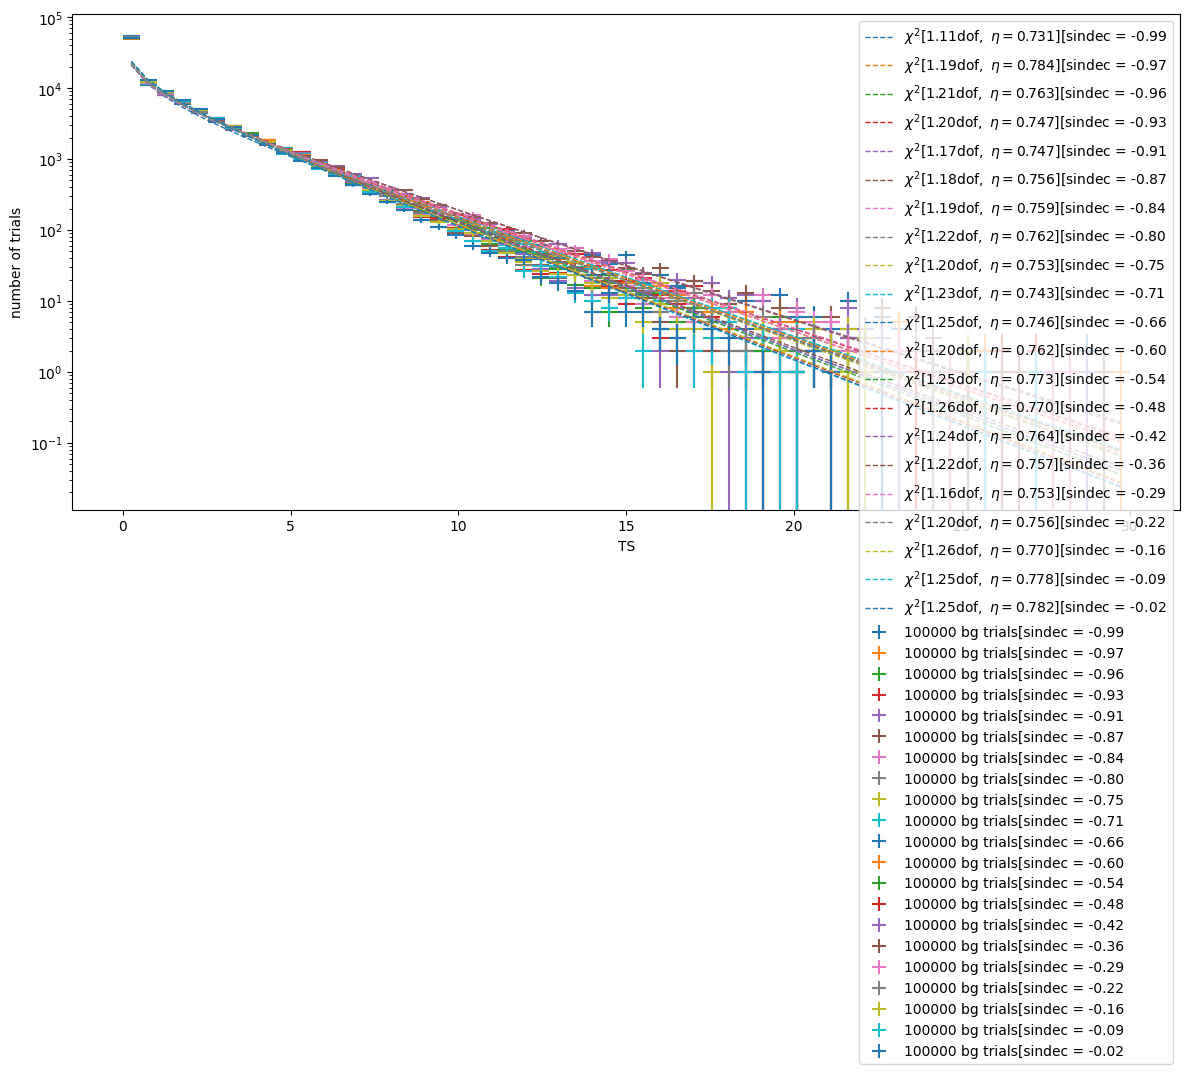

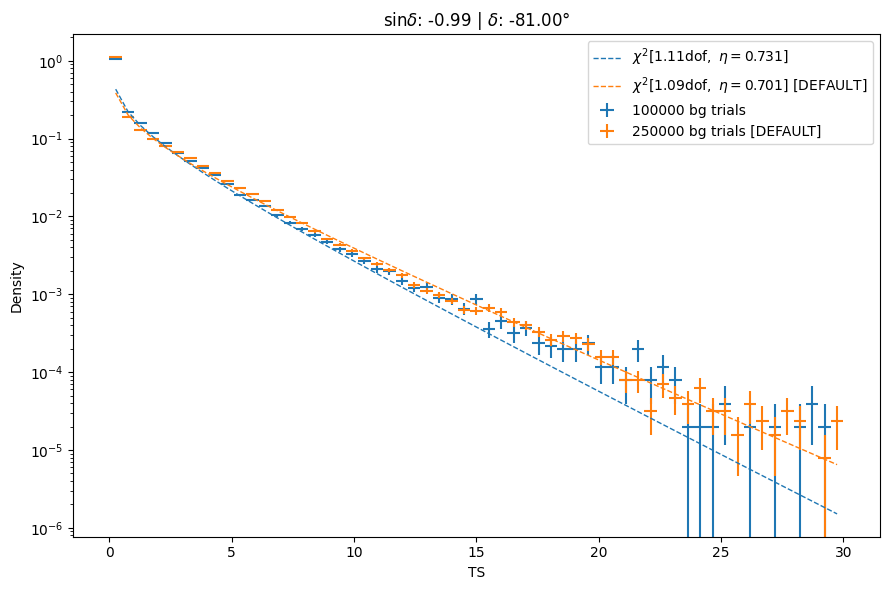

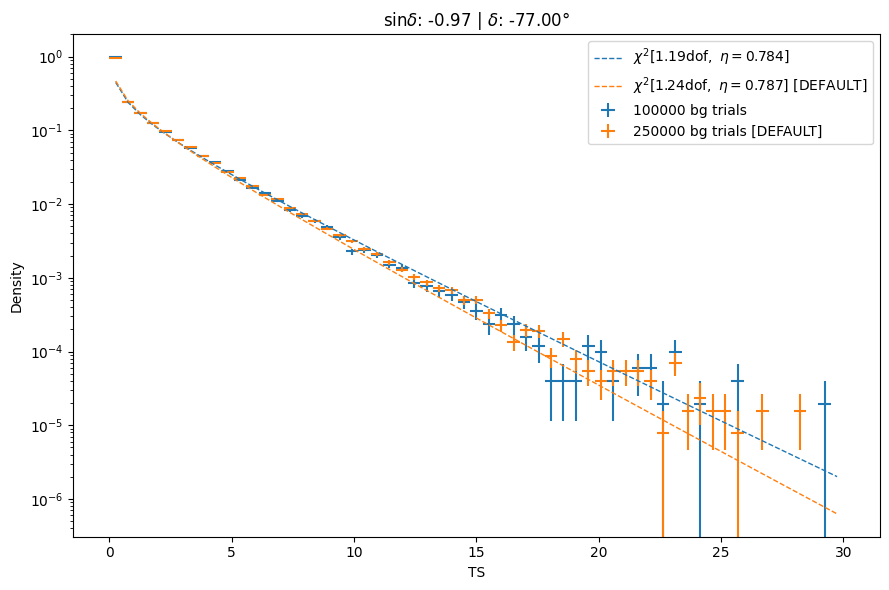

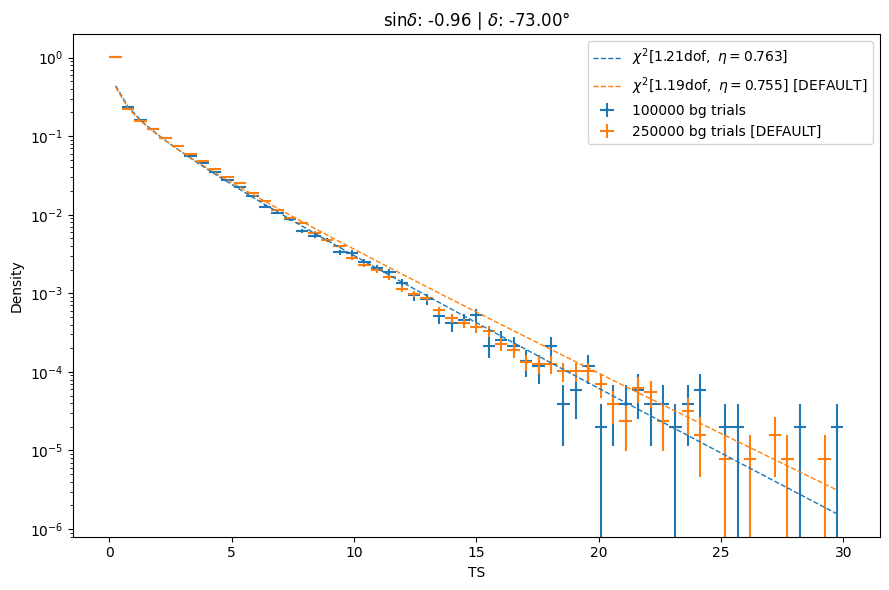

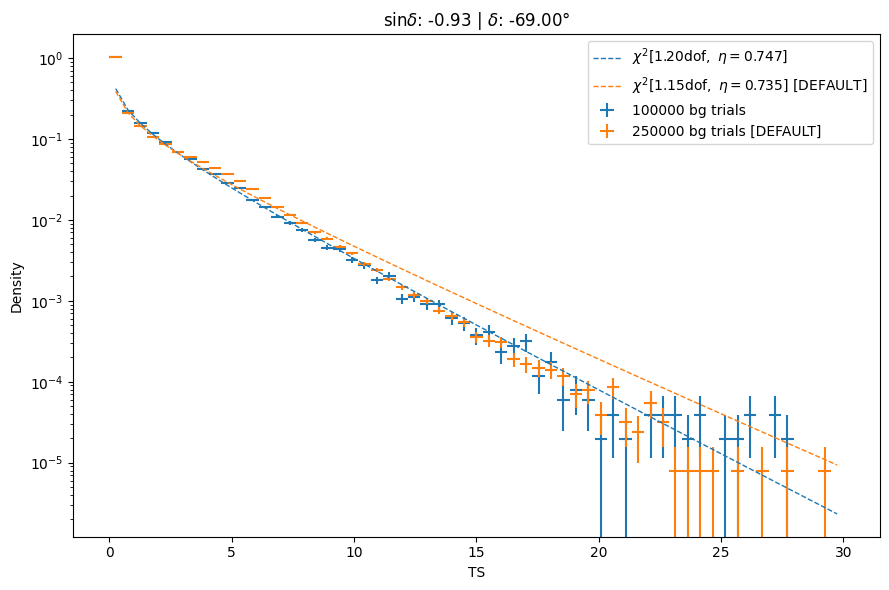

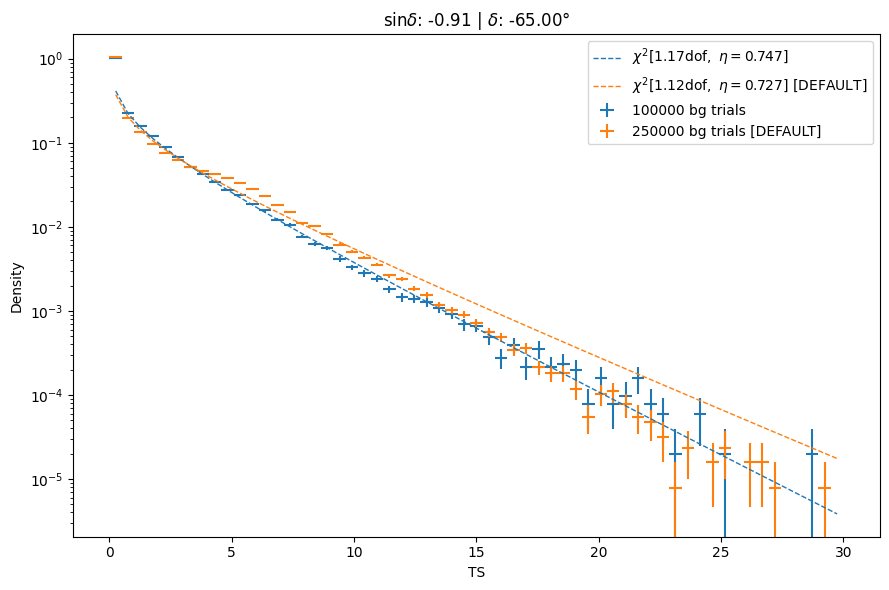

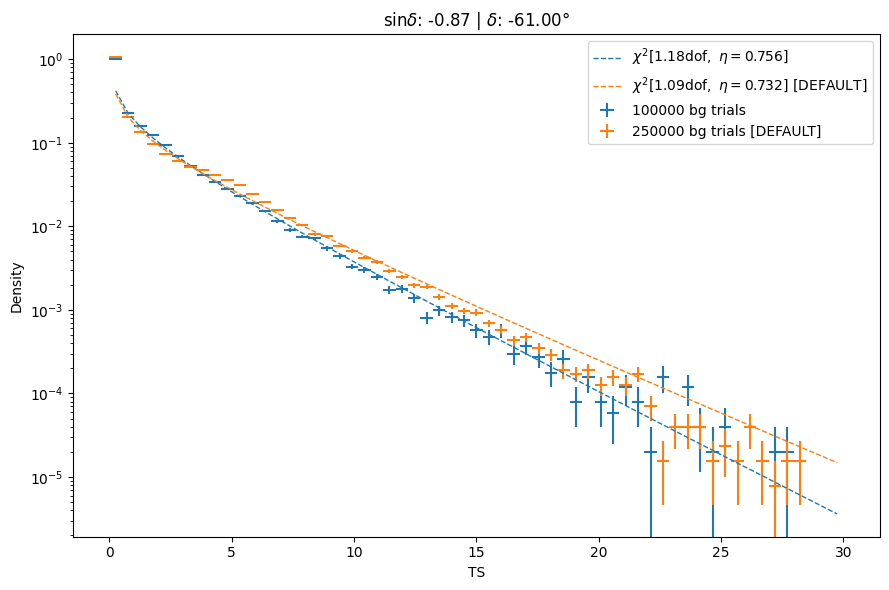

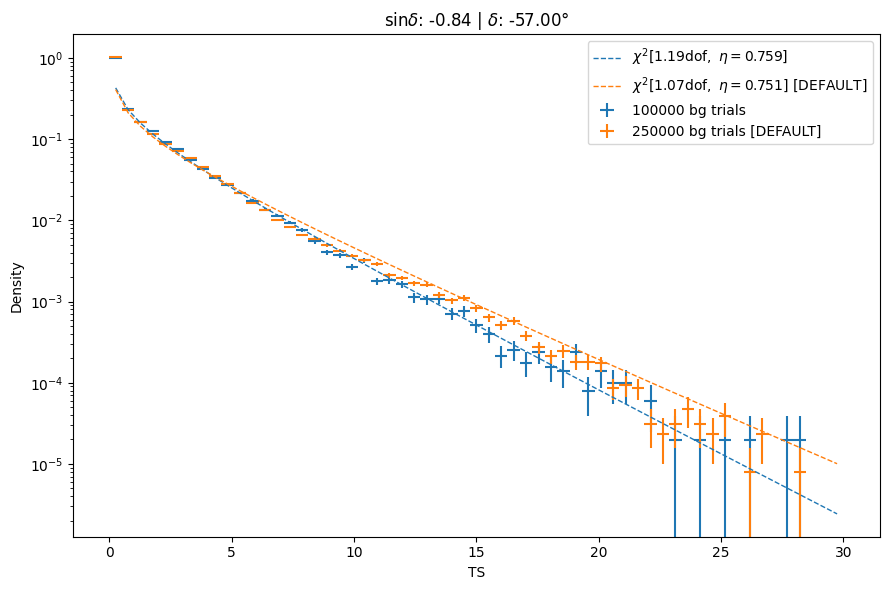

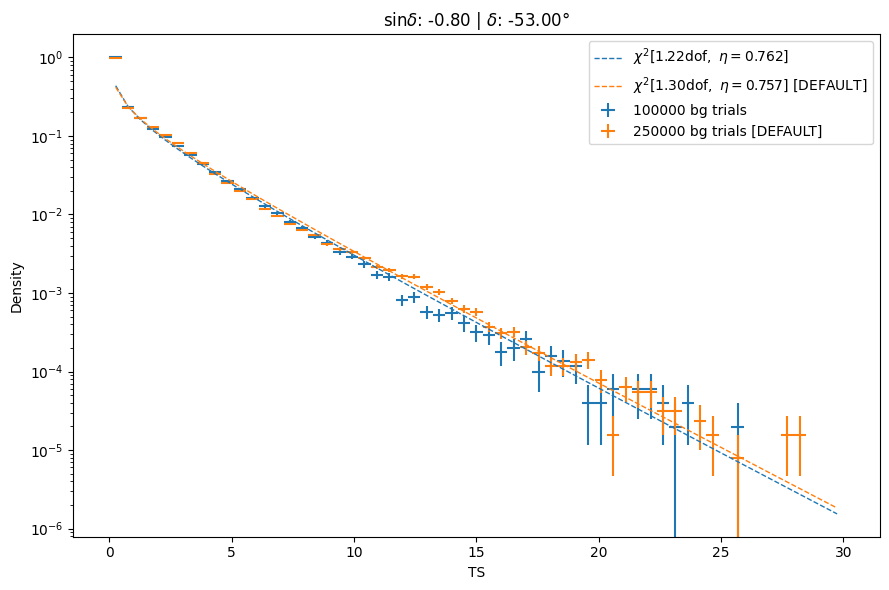

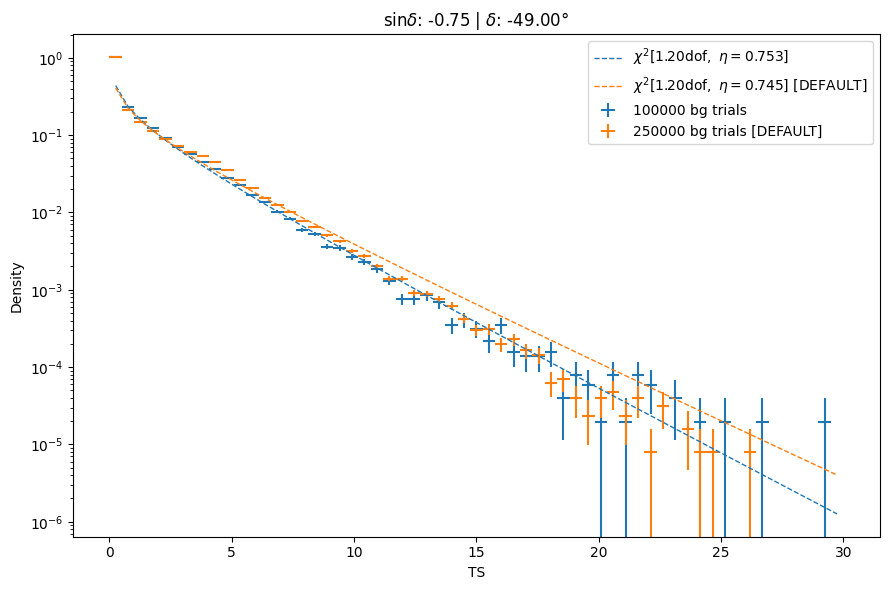

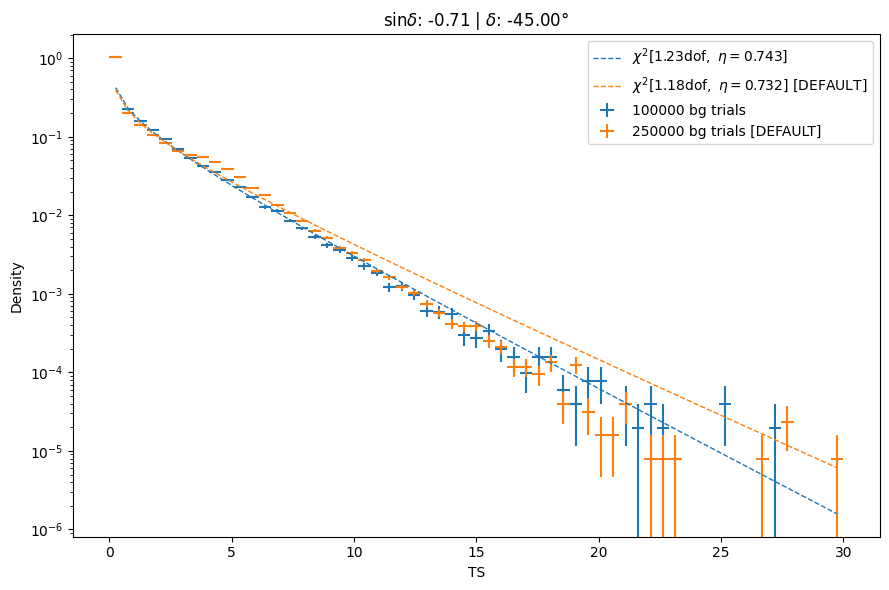

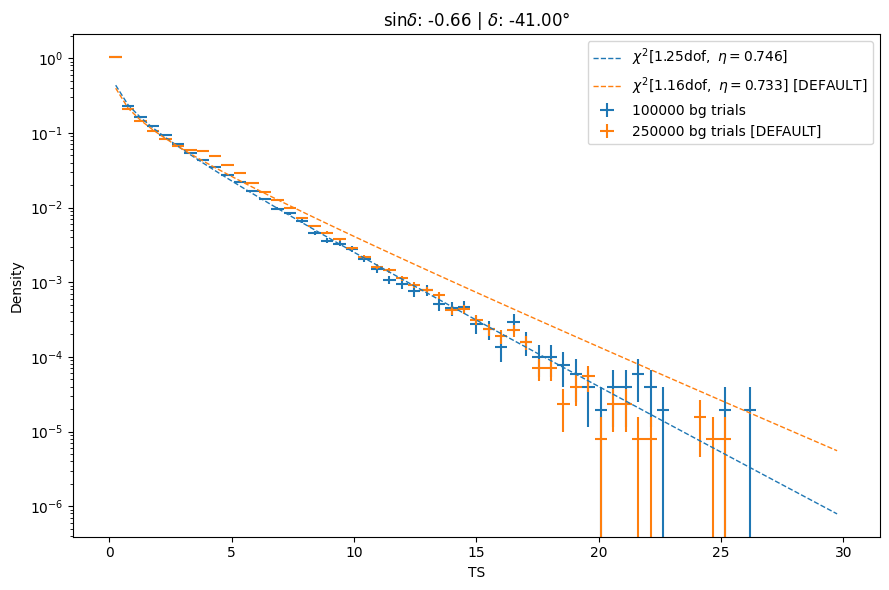

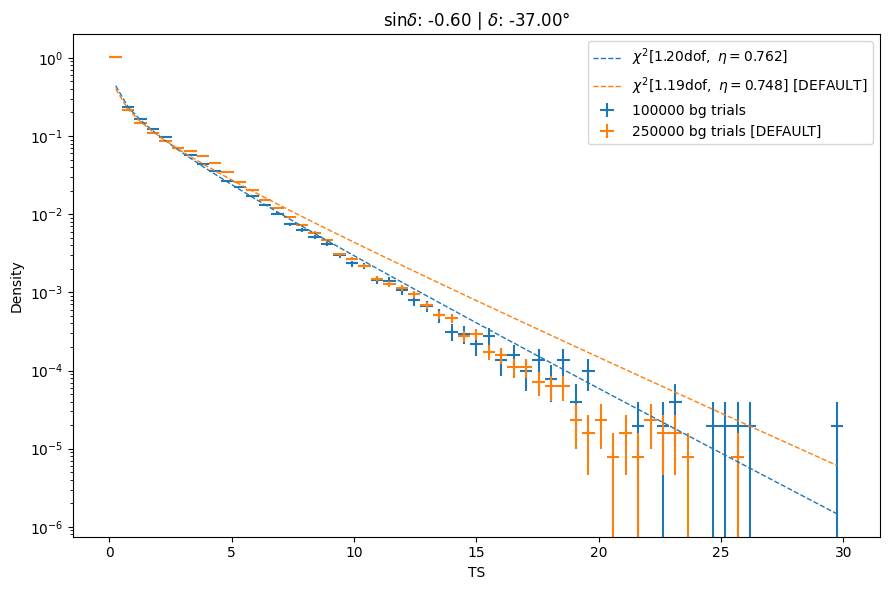

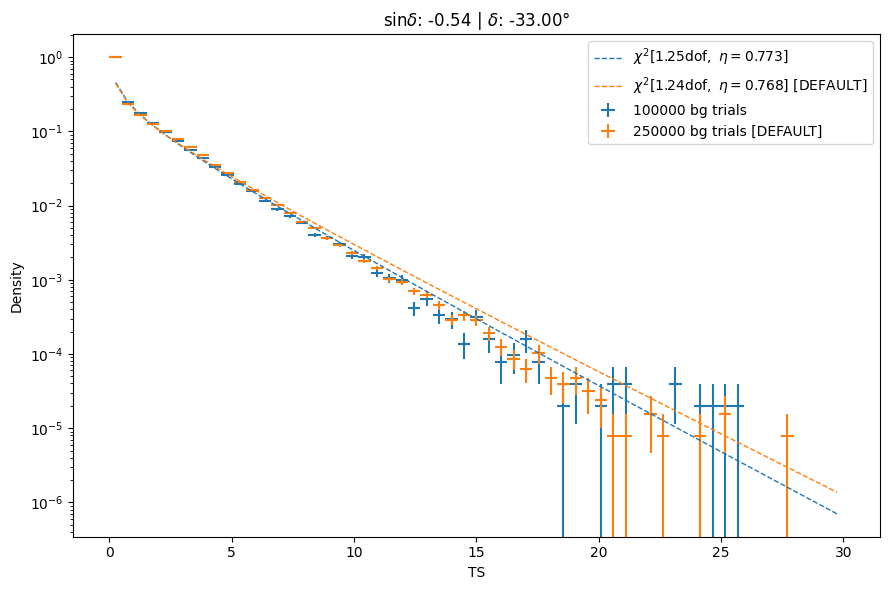

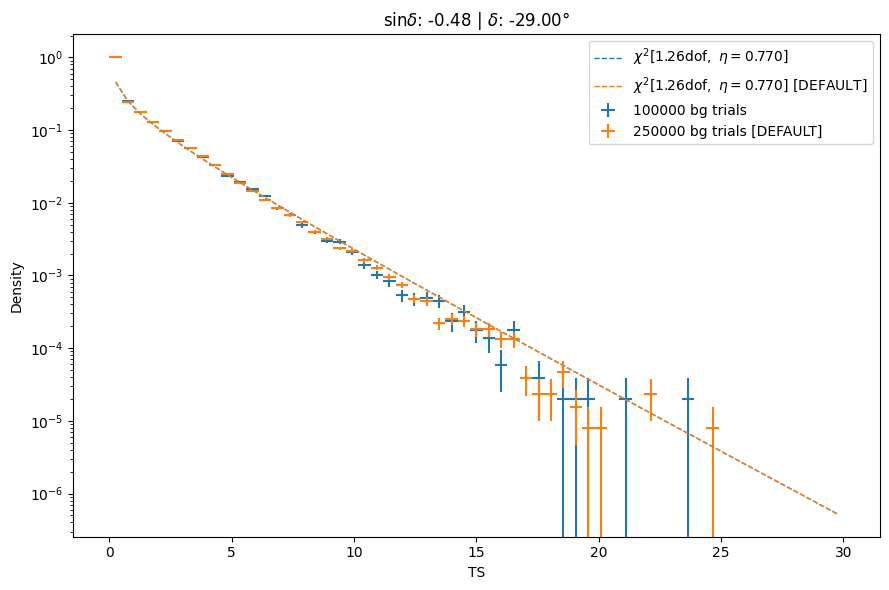

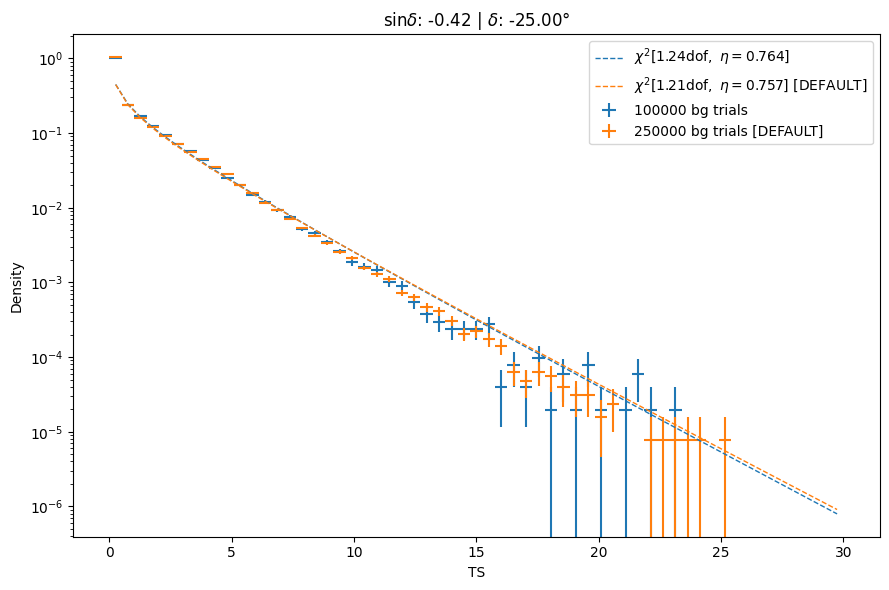

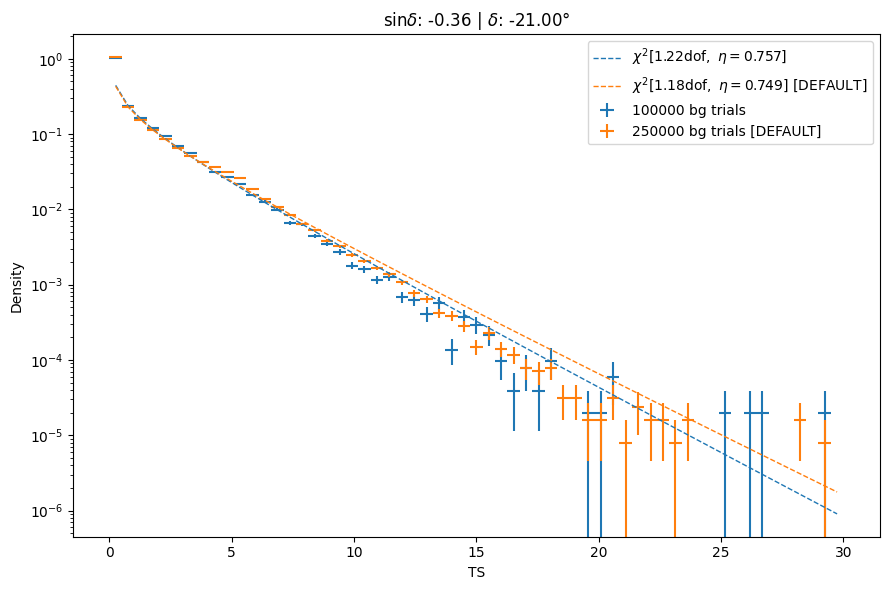

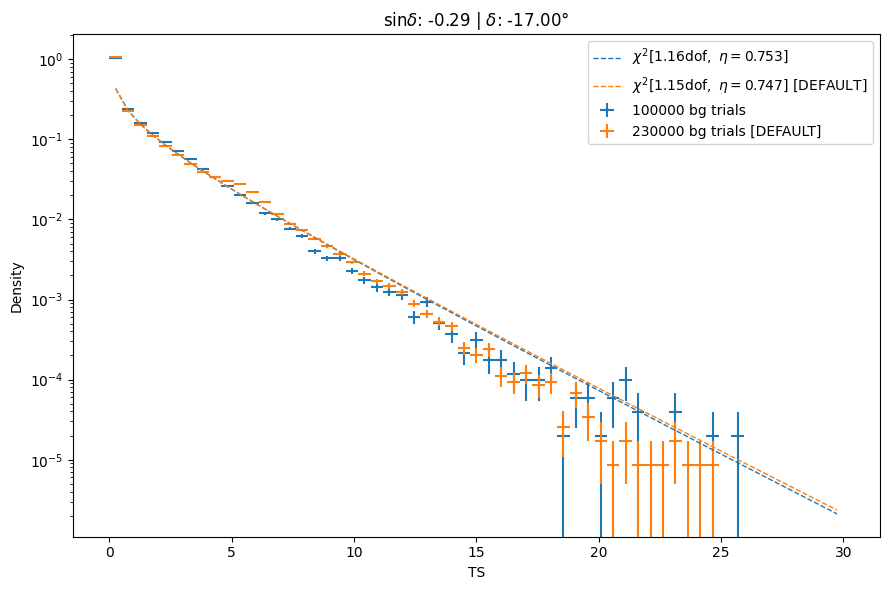

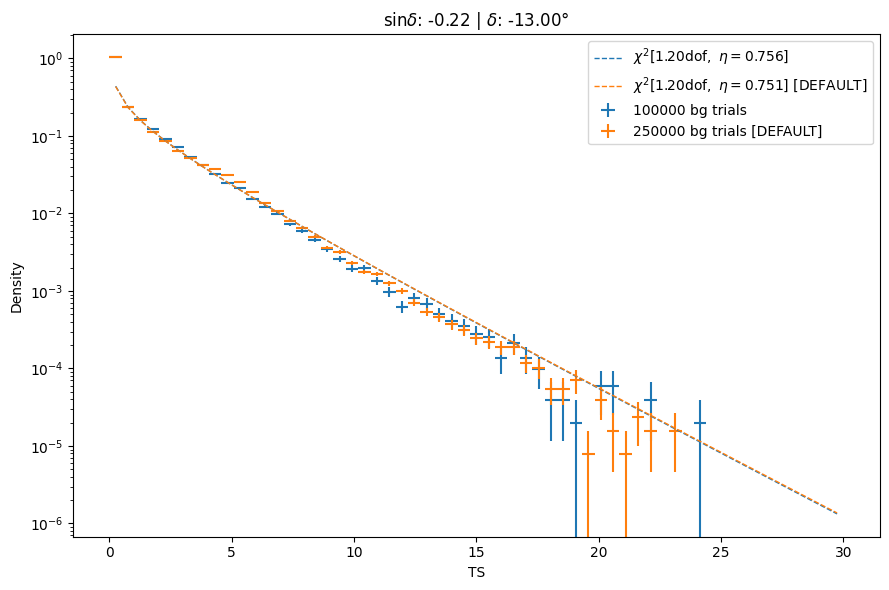

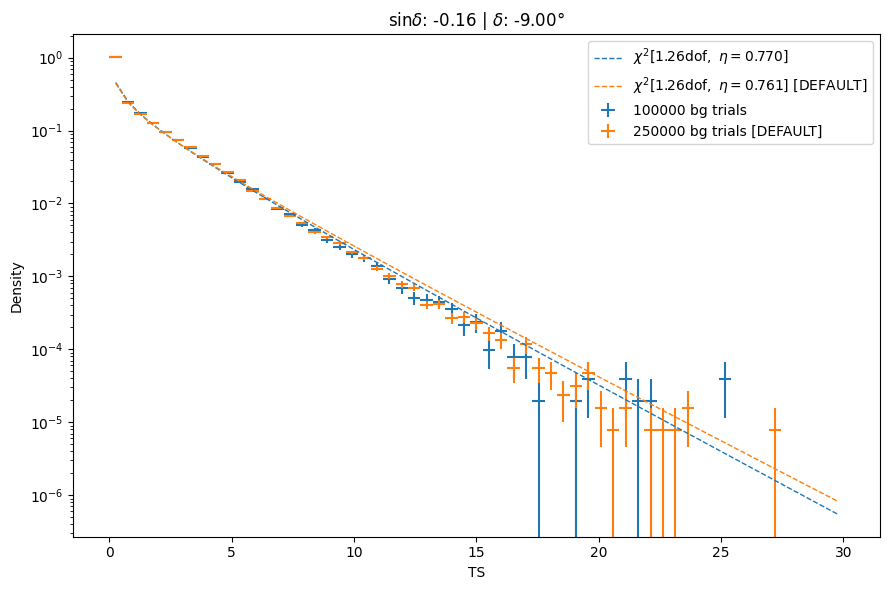

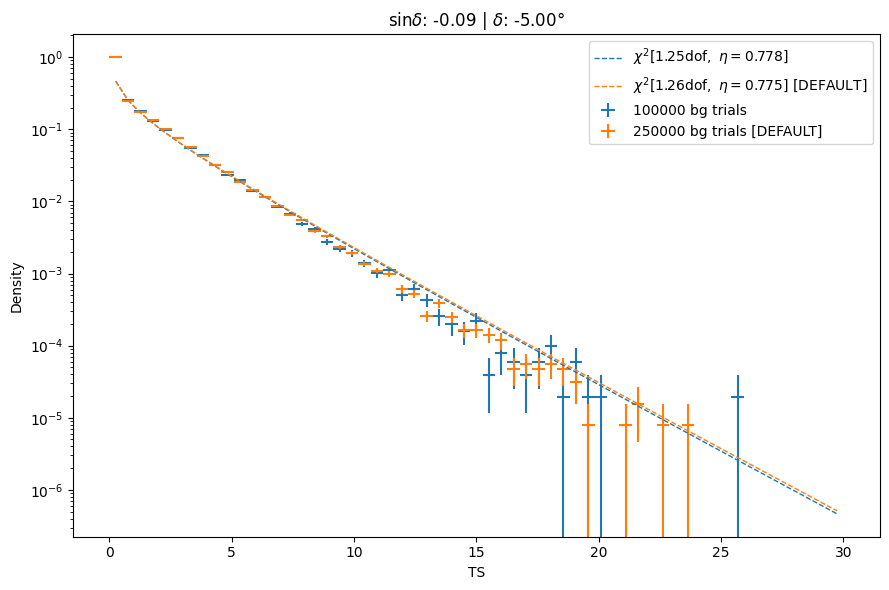

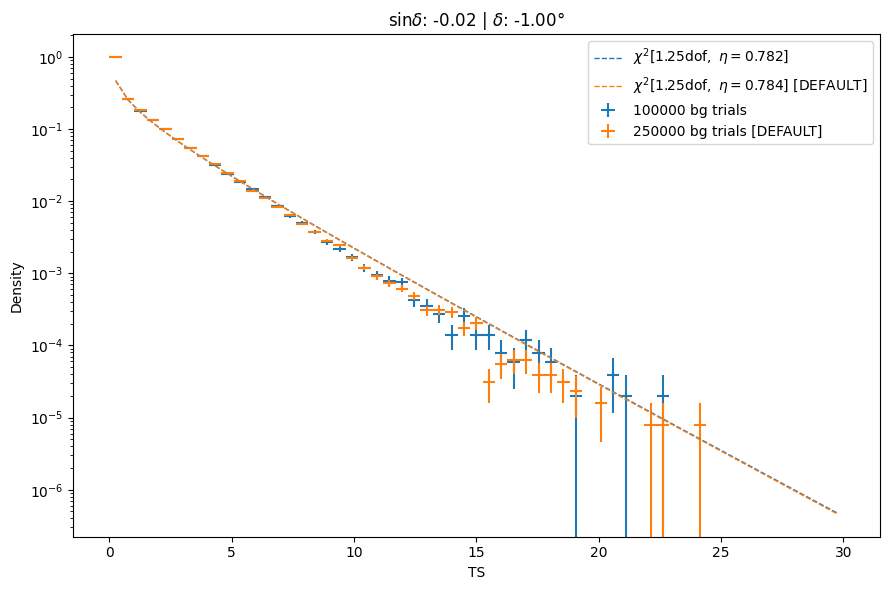

In [21]:
plot_mc_trials = False
bins = np.linspace(0, 30, 60)
density = True
fig, ax = plt.subplots(figsize=(12, 9))
color_cycler = cycle(colors)

for i,(sindec, (trials, _, seeds)) in  enumerate(trials_replace.items()):
    assert len(np.unique(seeds)) == len(seeds), seeds
    
    bg = cy.dists.Chi2TSD(trials)
    color = next(color_cycler)
    suffix = '[sindec = {:3.2f}'.format(sindec)
    plot_bkg_trials(
        bg, fig=fig, ax=ax, bins=bins,
        color=color,
        label='{} bg trials' + suffix, 
        label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$' +  suffix,
    )
    
    fig_i, ax_i = plt.subplots(figsize=(9, 6))
    plot_bkg_trials(
        bg, fig=fig_i, ax=ax_i, bins=bins,
        density=density,
    )
    
    # plot status quo
    dec_rounded = np.round(np.rad2deg(np.arcsin(sindec)), decimals=1)
    if dec_rounded in default_bg_chi2:
        plot_bkg_trials(
            default_bg_chi2[dec_rounded], fig=fig_i, ax=ax_i, bins=bins,
            density=density,
            color=colors[1],
            label='{} bg trials [DEFAULT]', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ [DEFAULT]',
        )
    else:
        print('Could not find DEFAULT trials for dec: {:3.3f}'.format(dec_rounded))
    
    # plot MC toy scrambles
    if plot_mc_trials:
        if (sindec, 0) in trials_replace_mc:

            # collect trials over all toy MC scrambles
            mc_trials = cy.utils.Events({'gamma': [], 'ns': [], 'ts': []})
            for iteration in range(n_iterations):
                key = (sindec, iteration)
                if key in trials_replace_mc:
                    mc_trials += trials_replace_mc[key][0]
                else:
                    print('No toy MC found for iteration {}'.format(iteration))
            bg_mc = cy.dists.Chi2TSD(mc_trials)

            # plot toy MC scrambles
            plot_bkg_trials(
                bg_mc, fig=fig_i, ax=ax_i, bins=bins,
                density=density,
                color=colors[2],
                label='{} bg trials [Toy MC]', 
                label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$ [Toy MC]',
            )

        else:
            print('Could not find Toy MC trials for dec: {:3.3f}'.format(dec_rounded))
    
    ax_i.set_title('$\sin \delta$: {:3.2f} | $\delta$: {:3.2f}°'.format(
        sindec, np.rad2deg(np.arcsin(sindec))))
    fig_i.tight_layout()
    fig_i.savefig(os.path.join(plot_dir, 'replacement_sampling_ts_dist_sindec_{:3.3f}{}.png'.format(sindec, file_addition)))

fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'replacement_sampling_ts_dists{}.png'.format(file_addition)))


#### Critical TS values

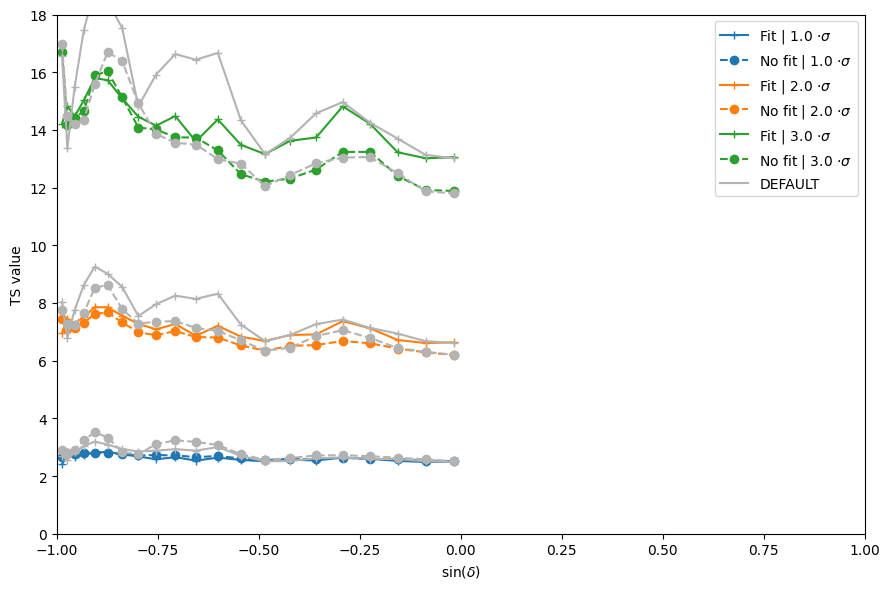

In [23]:
nsigmas = np.linspace(1, 5, 5)
nsigmas = np.linspace(1, 3, 3)
plot_mc_trials = False

sindec_values = []
fit_values = {n: [] for n in nsigmas}
no_fit_values = {n: [] for n in nsigmas}
default_fit_values = {n: [] for n in nsigmas}
default_no_fit_values = {n: [] for n in nsigmas}
mc_fit_values = {n: [] for n in nsigmas}
mc_no_fit_values = {n: [] for n in nsigmas}

for i,(sindec, (trials, _, seeds)) in  enumerate(trials_replace.items()):
    assert len(np.unique(seeds)) == len(seeds), seeds
    
    bg = cy.dists.Chi2TSD(trials)
    bg_nofit = cy.dists.TSD(trials)
    
    # --------------------
    # Get MC toy scrambles
    # --------------------
    if plot_mc_trials:
        if (sindec, 0) in trials_replace_mc:

            # collect trials over all toy MC scrambles
            trials_mc = cy.utils.Events({'gamma': [], 'ns': [], 'ts': []})
            for iteration in range(n_iterations):
                key = (sindec, iteration)
                if key in trials_replace_mc:
                    trials_mc += trials_replace_mc[key][0]
                else:
                    print('Not toy MC found for iteration {}'.format(iteration))
            mc_bg = cy.dists.Chi2TSD(trials_mc)
            mc_bg_nofit = cy.dists.TSD(trials_mc)
            found_mc = True
        else:
            print('Could not find Toy MC trials for dec: {:3.3f}'.format(dec_rounded))
            found_mc = False
    else:
        found_mc = False
    # --------------------
            
    
    sindec_values.append(sindec)
    
    for nsigma in nsigmas:
        fit_values[nsigma].append(bg.isf_nsigma(nsigma))
        no_fit_values[nsigma].append(bg_nofit.isf_nsigma(nsigma))
        
        # get status quo
        dec_rounded = np.round(np.rad2deg(np.arcsin(sindec)), decimals=1)
        if dec_rounded in default_bg_chi2:
            default_fit_values[nsigma].append(default_bg_chi2[dec_rounded].isf_nsigma(nsigma))
            default_no_fit_values[nsigma].append(default_bg[dec_rounded].isf_nsigma(nsigma))
        else:
            print('Could not find DEFAULT trials for dec: {:3.3f}'.format(dec_rounded))
            default_fit_values.append(np.nan)
            default_no_fit_values.append(np.nan)
        
        # get toy MC
        if found_mc:
            mc_fit_values[nsigma].append(mc_bg.isf_nsigma(nsigma))
            mc_no_fit_values[nsigma].append(mc_bg_nofit.isf_nsigma(nsigma))
        else:
            mc_fit_values[nsigma].append(np.nan)
            mc_no_fit_values[nsigma].append(np.nan)
    
    
fig, ax = plt.subplots(figsize=(9, 6))
color_cycler = cycle(colors)
color_mc = '#E6007E'

for i, n in enumerate(nsigmas):
    color = next(color_cycler)
    ax.plot(
        sindec_values, fit_values[n], 
        color=color, ls='-', marker='+', 
        label='Fit | {} $\cdot \sigma$'.format(n),
    )
    ax.plot(
        sindec_values, no_fit_values[n], 
        color=color, ls='--', marker='o', 
        label='No fit | {} $\cdot \sigma$'.format(n),
    )
    
    # default curves
    ax.plot(
        sindec_values, default_fit_values[n], 
        color='0.7', ls='-', marker='+', 
    )
    ax.plot(
        sindec_values, default_no_fit_values[n], 
        color='0.7', ls='--', marker='o', 
    )
    
    # toy MC curves
    if plot_mc_trials:
        ax.plot(
            sindec_values, mc_fit_values[n], 
            color=color_mc, ls='-', marker='+', 
        )
        ax.plot(
            sindec_values, mc_no_fit_values[n], 
            color=color_mc, ls='--', marker='o', 
        )

if plot_mc_trials:
    ax.plot(np.nan, np.nan, color=color_mc, label='Toy MC')
ax.plot(np.nan, np.nan, color='0.7', label='DEFAULT')
    
    
ax.set_xlabel('$\sin (\delta)$')
ax.set_ylabel('TS value')
ax.set_xlim(-1., 1.)
ax.set_ylim(0., 18.)
ax.legend()
ax.set_title(file_addition.replace('_', ' '))
fig.tight_layout()
fig.savefig(os.path.join(plot_dir, 'replacement_sampling_critical_ts{}.png'.format(file_addition)))